<a href="https://colab.research.google.com/github/HJBJalaly/DLeeg/blob/master/best%20channel/Mine/Search_2Ch_Base_Normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install mne

     |████████████████████████████████| 6.4MB 2.8MB/s 


In [3]:
'''
Search among 30 selected channels to find the best accuracy with two orthogonal channels (Fisrt one is fixed)

'''

'\nSearch among 20 selected channels to find the best accuracy with only one channel\n\n'

In [4]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import numpy as np
import math
import random

# For clear memory
import gc

#
import copy 
import csv
import datetime
import time


# To download file from google drive
from google.colab import files

# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers

# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


Automatically created module for IPython interactive environment


In [0]:
# Parameters:

subject_number=2
task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
sample_shift = 4 #step len
window_len= 20
EpochNum=2

Best1Channel=61 #Oz
Search_Space_Channel = [21,23]#,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
Search_Space_Channel_Name=["Fp1","Fp2"]#,"F7","F3","Fz","F4","F8","T7","C3","Cz","C4","T8","P7","P3","Pz","P4","P8","O1","Oz","O2"]

# Channel Indexes:
#   Fp1,21
#   Fp2,23
#   F7,29
#   F3,31
#   Fz,33
#   F4,35
#   F8,36
#   T7,40
#   C3,8
#   Cz,10
#   C4,12
#   T8,41
#   P7,46
#   P3,48
#   Pz,50
#   P4,52
#   P8,54
#   O1,60
#   Oz,61
#   O2,62

#   T9,42
#   T10,43


In [6]:
# load dataset in array
task_index = [1] # task: REO
task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_number
for x in range(subject_number):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index)

list_rawdata = np.zeros((subject_number,task_number), dtype='object')

for i in range(subject_number):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


# # load dataset in array
# list_raw_fnames = [[0]*2]*subject_number
# for x in range(subject_number):
#     list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,[1,2])

# #list_rawdata1 = np.zeros((subject_number,2), dtype='object')
# list_rawdata = np.zeros((subject_number,2), dtype='object')

# for i in range(subject_number):
#     for j in range(2):
#         list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)
       

Using default location ~/mne_data for EEGBCI...
Creating ~/mne_data
[........................................] 100.00% (  1.2 MB,   881 kB/s) |
Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
[........................................] 100.00% (  1.2 MB,   945 kB/s) /
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


In [7]:
# img for each subject
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec) / sample_shift) +1 - window_len +1
test_start_index=subject_img_number - math.floor(subject_img_number/4) 

train_number =  test_start_index 
test_number = subject_img_number - test_start_index
print("Train sample:",train_number)
print("Test sample:",test_number)

# ch_number = len(list_channel)

# train_img = np.zeros((train_number*subject_number, ch_number, window_len + 1, 160), dtype = float)
# train_label =[]

# test_img = np.zeros((test_number*subject_number, ch_number, window_len, 160), dtype = float)
# test_label =[]

# print("train image dims:",train_img.shape)

Train sample: 1757
Test sample: 585


In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA

In [9]:
#####################################################################################################
# seacrh all channels
SearchSpaceResult=np.zeros((len(Search_Space_Channel),6),dtype = float)

for IndexCh in range(len(Search_Space_Channel)):
    
    #################################################################################################
    # Print Iteration
    print("#################################################################################################")
    print("Index:", IndexCh," > Channel:", Search_Space_Channel_Name[IndexCh])
    
    
    #################################################################################################
    # Reset Model and Data Arrays
    list_channel=[Best1Channel, Search_Space_Channel[IndexCh]]
    ch_number=len(list_channel)
    
    train_img = np.zeros((train_number*subject_number, ch_number, window_len + 1, 160), dtype = float)
    train_label =[]

    test_img = np.zeros((test_number*subject_number, ch_number, window_len, 160), dtype = float)
    test_label =[]
    
    list_rawdataTemp=list_rawdata.copy()

    #################################################################################################
    # Fill Data Arrays
    for s in range(subject_number):

        DataAllChannelsRaw, times =(list_rawdataTemp[s][0][:64,:9600])


        # Extrac Channel T9 or T10 as Baseline
        DataChannelT9Raw =DataAllChannelsRaw[43]# Ch T9 (42) or T10 (43)

        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        DataChannelsRaw   =np.zeros((ch_number,times.size),dtype = float)
        DataChannelsNormal=np.zeros((ch_number,times.size),dtype = float)
        DataChannelsOrt   =np.zeros((ch_number,times.size),dtype = float)
        for i in range(len(list_channel)):
            DataChannelsRaw[i]=DataAllChannelsRaw[list_channel[i]].copy()# -DataChannelT9Raw
            
            ch_max = np.append(ch_max, max(DataChannelsRaw[i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[i])) # min for each cannel
            
            DataChannelsNormal[i]=normalize_channel_data(DataChannelsRaw[i].copy(), i, ch_min, ch_max)

    
        # Orthogonal Channel
        DataChannelsOrt[0]=DataChannelsNormal[0]
        DataChannelsOrt[1]=DataChannelsNormal[1]-ProjectionVector(DataChannelsNormal[0],DataChannelsNormal[1])
    

        for j in range (subject_img_number):
            for i in range(len(list_channel)): # فقط کانال های با اندیس مشخص را دربرمیگیرد
                for z in range (window_len):
                    ExtractedData=DataChannelsOrt[i,0+(j+z)*sample_shift:sampel_number_per_sec+(j+z)*sample_shift]

                    if j <test_start_index :
                        train_img[s*train_number + j][i][z] = ExtractedData
                        if z==window_len-1 :
                            train_img[s*train_number + j][i][z+1] = s
                    else:
                         test_img[s*test_number + j - test_start_index][i][z] = ExtractedData
            if j >=test_start_index :
                test_label = np.append(test_label, (s))
                
        
    #################################################################################################
    #shuffle train img array
    train_img_shuffle = train_img.copy()

    np.random.shuffle(train_img_shuffle)

    train_img_2 = np.zeros((train_number*subject_number, ch_number, window_len, 160), dtype = float)

    # img label 
    train_img_shuffle_len =len(train_img_shuffle)
    for i in range(train_img_shuffle_len):
        train_label = np.append(train_label, (train_img_shuffle[i][0][window_len][0] ))
        for j in range (ch_number):
            train_img_2[i][j] = np.delete(train_img_shuffle[i][j], window_len, axis=0)
            
    
    #################################################################################################
    # valid & train
    train_label = to_categorical(train_label, subject_number)
    test_label = to_categorical(test_label, subject_number)
    
    validation_index = math.floor( len(train_img_2) * 0.2)

    x_train =train_img_2[validation_index:]
    y_train =train_label[validation_index:]    
    x_valid =train_img_2[:validation_index]
    y_valid =train_label[:validation_index]
    #x_train =train_img_2[:20000]
    #y_train =train_label[:20000]
    #x_valid =train_img_2[20000:]
    #y_valid =train_label[20000:]


    #################################################################################################
    # Create Model
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,160), data_format= "channels_first" ))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(subject_number, activation = 'softmax'))
    
    model.compile(loss= 'categorical_crossentropy',
                  optimizer= optimizers.RMSprop(lr= 1e-4),
                  metrics = ['acc'])
    
    #################################################################################################
    # Train the Model
    history = model.fit(
        x_train,
        y_train,
        epochs =EpochNum ,
        batch_size = 20,
        validation_data = (x_valid, y_valid))
    
    #################################################################################################
    # Evalute the Model
    TestResult=model.evaluate(test_img, test_label)
    
    #################################################################################################
    # Save Result
    SearchSpaceResult[IndexCh][0]=history.history['loss'][EpochNum-1]
    SearchSpaceResult[IndexCh][1]=history.history['acc'][EpochNum-1]
    SearchSpaceResult[IndexCh][2]=history.history['val_loss'][EpochNum-1]
    SearchSpaceResult[IndexCh][3]=history.history['val_acc'][EpochNum-1]
    
    SearchSpaceResult[IndexCh][4]=TestResult[0]
    SearchSpaceResult[IndexCh][5]=TestResult[1]

    #################################################################################################
    # Erase Memory
    del train_img
    del test_img
    del list_rawdataTemp
    del DataAllChannelsRaw
    del DataChannelsRaw
    del DataChannelsNormal
    del DataChannelsOrt
    del train_img_shuffle
    del train_img_2
    del x_train
    del y_train
    del x_valid
    del y_valid
    del model
    
    gc.collect()


#################################################################################################
Index: 0  > Channel: Fp1






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2812 samples, validate on 702 samples
Epoch 1/2
2812/2812 [==============================] - 6s 2ms/step - loss: 0.6897 - acc: 0.5509 - val_loss: 0.6721 - val_acc: 0.5684
Epoch 2/2
1170/1170 [==============================] - 0s 314us/step
#################################################################################################
Index: 1  > Channel: Fp2
Train on 2812 samples, validate on 702 samples
Epoch 1/2
2812/2812 [==============================] - 3s 945us/step - loss: 0.6846 - acc: 0.5537 - val_loss: 0.6958 - val_acc: 0.4701
Epoch 2/2
1170/1170 [==============================] - 0s 188us/step


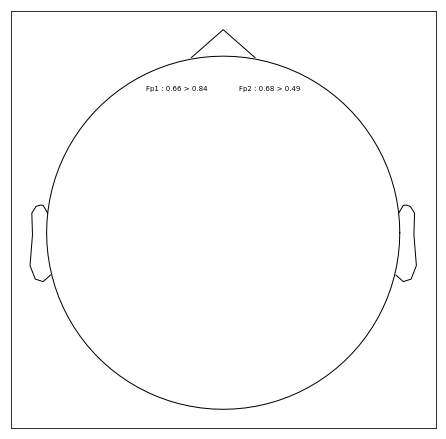

In [11]:
## Visualize Results and Save Results
Today = datetime.date.today()
TodayStr = Today.strftime("%Y%m%d")
ResultFileName='SearchSpaceResult_2Ch_'+TodayStr+'_S'+str(EpochNum)+'.csv'
ChannelFileName='ChannelNames_2Ch_'+TodayStr+'_S'+str(EpochNum)+'.csv'
ImageFileName='SearchSpaceResult_2Ch_'+TodayStr+'_S'+str(EpochNum)+'.pdf'


# Visualize
biosemi_layout = mne.channels.read_layout('biosemi')
biosemi_Acc=copy.deepcopy(biosemi_layout)

for i in range(len(biosemi_Acc.names)):
    biosemi_Acc.names[i]=' '

    
for i in range(len(Search_Space_Channel)):
    index=biosemi_layout.names.index(Search_Space_Channel_Name[i])
    biosemi_Acc.names[index]=biosemi_layout.names[index]+" : "+str(np.round(SearchSpaceResult[i][1],2))+\
                                                         " > "+str(np.round(SearchSpaceResult[i][5],2))

ImageEEG=biosemi_Acc.plot()
# plt.title("Channel Name : Training Acc.  > Test Acc.",pad=-12)


# Save
ImageEEG.savefig(ImageFileName)

with open(ResultFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(SearchSpaceResult)

with open(ChannelFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(Search_Space_Channel)
    spamwriter.writerow(Search_Space_Channel_Name)
    
# Downlaod
time.sleep(10)
files.download(ResultFileName)
files.download(ChannelFileName)
files.download(ImageFileName)
